# Model Fitting: SGD

import numpy as np
import scipy.stats
import scipy.optimize
import pandas as pd
import pickle
import random

import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

In [1]:
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

import pandas as pd
import pickle
import random
import scipy.optimize
import time

import autograd.numpy as np
import autograd.numpy.random as npr
from autograd import grad
from autograd.scipy.stats import norm

## Data Manipulation

In [2]:
player_info = pd.read_csv("clean-data/player_info_pergame.csv")
game_outcomes = pd.read_csv("clean-data/game_outcomes_15-16.csv")

In [3]:
player_info.head()

,Player,Tm,2015-16,Pos,Age,G,GS,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,Kobe Bryant,Los Angeles Lakers,25000000,SF,37,66,66,28.2,6.0,16.9,...,0.826,0.6,3.1,3.7,2.8,0.9,0.2,2.0,1.7,17.6
1,Joe Johnson,Brooklyn Nets,24894863,SF,34,81,81,33.4,4.7,10.6,...,0.831,0.6,3.0,3.6,3.9,0.8,0.0,2.0,1.8,12.2
2,LeBron James,Cleveland Cavaliers,22971000,SF,31,76,76,35.6,9.7,18.6,...,0.731,1.5,6.0,7.4,6.8,1.4,0.6,3.3,1.9,25.3
3,Carmelo Anthony,New York Knicks,22875000,SF,31,72,72,35.1,7.9,18.2,...,0.829,1.4,6.4,7.7,4.2,0.9,0.5,2.4,2.5,21.8
4,Dwight Howard,Houston Rockets,22359364,C,30,71,71,32.1,5.2,8.5,...,0.489,3.4,8.4,11.8,1.4,1.0,1.6,2.3,3.1,13.7


In [4]:
game_outcomes.head()

,Visitor/Neutral,PTS,Home/Neutral,PTS.1,Year,diff,Visitor_Index,Home_Index
0,Detroit Pistons,106.0,Atlanta Hawks,94.0,2016,12.0,5,26
1,Cleveland Cavaliers,95.0,Chicago Bulls,97.0,2016,-2.0,25,11
2,New Orleans Pelicans,95.0,Golden State Warriors,111.0,2016,-16.0,24,10
3,Philadelphia 76ers,95.0,Boston Celtics,112.0,2016,-17.0,4,6
4,Chicago Bulls,115.0,Brooklyn Nets,100.0,2016,15.0,11,27


Make indices for home/visitor

In [5]:
def make_guest_host_mat(game_outcomes_df):
    '''
    Makes a matrix for guests and hosts. Each row of each
    matrix corresponds to one matchup. All elements of each row
    are zero except the ith one (different for each row).
    For the guest matrix, the ith entry in row j means that in game j,
    the guest team was team i. In the host matrix, the ith entry in
    row j means that the host team was team i
    '''
    
    def make_matrix(mat, indices):
        '''given a matrix and indices, sets the right one in each row
        to be true'''
        for (i, ind) in enumerate(indices):
            mat[i, ind] = True
        
    nrows = game_outcomes_df.shape[0]
    ncols = np.max(game_outcomes_df['Visitor_Index'] + 1)
    
    guest_matrix = np.zeros((nrows, ncols), dtype = bool)
    host_matrix = np.zeros((nrows, ncols), dtype = bool)
    
    make_matrix(guest_matrix, game_outcomes_df['Visitor_Index'].values)
    make_matrix(host_matrix, game_outcomes_df['Home_Index'].values)
    
    return(guest_matrix, host_matrix)

In [6]:
guest_matrix, host_matrix = make_guest_host_mat(game_outcomes)

Read the player info

In [7]:
with open("clean-data/host_team_line_up.pkl", "rb") as f:
    host_team_line_up = pickle.load(f)

with open("clean-data/guest_team_line_up.pkl", "rb") as f:
    guest_team_line_up = pickle.load(f)

In [8]:
off_rating = player_info['PTS'].values + player_info['AST'].values
def_rating = player_info['BLK'].values + player_info["STL"].values + player_info['DRB'].values

In [9]:
player_info[player_info['PTS'] > 20]

,Player,Tm,2015-16,Pos,Age,G,GS,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
2,LeBron James,Cleveland Cavaliers,22971000,SF,31,76,76,35.6,9.7,18.6,...,0.731,1.5,6.0,7.4,6.8,1.4,0.6,3.3,1.9,25.3
3,Carmelo Anthony,New York Knicks,22875000,SF,31,72,72,35.1,7.9,18.2,...,0.829,1.4,6.4,7.7,4.2,0.9,0.5,2.4,2.5,21.8
7,Kevin Durant,Oklahoma City Thunder,20158622,SF,27,72,72,35.8,9.7,19.2,...,0.898,0.6,7.6,8.2,5.0,1.0,1.2,3.5,1.9,28.2
10,Brook Lopez,Brooklyn Nets,20000000,C,27,73,73,33.7,8.1,15.8,...,0.787,2.8,5.1,7.8,2.0,0.8,1.7,2.4,2.9,20.6
16,Blake Griffin,Los Angeles Clippers,18907725,PF,26,35,35,33.4,8.6,17.2,...,0.727,1.5,6.9,8.4,4.9,0.8,0.5,2.4,2.7,21.4
17,Paul George,Indiana Pacers,17120106,SF,25,81,81,34.8,7.5,17.9,...,0.860,1.0,6.0,7.0,4.1,1.9,0.4,3.3,2.8,23.1
18,Russell Westbrook,Oklahoma City Thunder,16744218,PG,27,80,80,34.4,8.2,18.1,...,0.812,1.8,6.0,7.8,10.4,2.0,0.3,4.3,2.5,23.5
19,Kawhi Leonard,San Antonio Spurs,16500000,SF,24,72,72,33.1,7.7,15.1,...,0.874,1.3,5.5,6.8,2.6,1.8,1.0,1.5,1.8,21.2
25,James Harden,Houston Rockets,15756438,SG,26,82,82,38.1,8.7,19.7,...,0.860,0.8,5.3,6.1,7.5,1.7,0.6,4.6,2.8,29.0
28,Klay Thompson,Golden State Warriors,15500000,SG,25,80,80,33.3,8.1,17.3,...,0.873,0.4,3.4,3.8,2.1,0.8,0.6,1.7,1.9,22.1


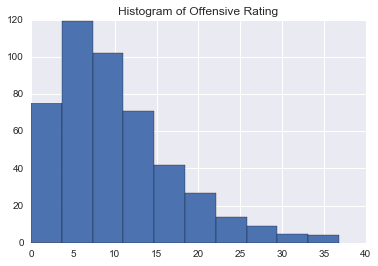

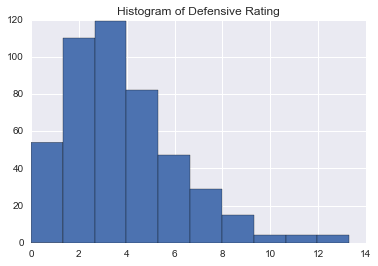

In [10]:
plt.hist(off_rating)
plt.title("Histogram of Offensive Rating")
plt.show()

plt.hist(def_rating)
plt.title("Histogram of Defensive Rating")
plt.show()

In [11]:
game_diff = game_outcomes['diff'].values

## Stochastic Gradient Descent

In [13]:
host_lineup_arr = np.array(host_team_line_up)
guest_lineup_arr = np.array(guest_team_line_up)
nplayers = player_info.shape[0]
nteams = host_matrix.shape[1]
print("Number of players: %d. Number of teams: %d." %(nplayers, nteams))

Number of players: 468. Number of teams: 30.


In [14]:
def split_params(coefs, nplayers, nteams):
    '''
    Split the parameters
    first are the beta0 for each team
    then the beta for each player
    then the gamma0 for each team
    then the gamma for each player'''
    assert(coefs.shape == (2*(nplayers+nteams) + 1,))
    
    beta0 = coefs[:nteams]
    beta_player = coefs[nteams:(nplayers + nteams)]
    gamma0 = coefs[(nplayers + nteams):(nplayers + 2*nteams)]
    gamma_player = coefs[(nplayers + 2*nteams):-1]
    
    # parameterize sigma by its log
    logsigma = coefs[-1]
    
    assert(beta0.shape == (nteams,))
    assert(beta_player.shape == (nplayers,))
    assert(beta0.shape == (nteams,))
    assert(gamma_player.shape == (nplayers,))
    
    
    return (beta0, beta_player, gamma0, gamma_player, logsigma)

In [16]:
def negloglik(coefs, game_diff, off_rating, def_rating, nplayers, nteams,
           guest_matrix, host_matrix, guest_lineup_arr, host_lineup_arr,
           lam = 0):
    ''' evaluate the negative log likelihood for our basketball model '''
    beta0, betas, gamma0, gammas, logsigma = \
            split_params(coefs, nplayers, nteams)
    
    ngames = game_diff.shape[0]
    
    guest_off_0 = np.dot(guest_matrix, beta0)
    guest_def_0 = np.dot(guest_matrix, gamma0)
    host_off_0 = np.dot(host_matrix, beta0)
    host_def_0 = np.dot(host_matrix, gamma0)
    
    guest_off = guest_off_0 + np.dot(guest_lineup_arr, betas * off_rating)
    guest_def = guest_def_0 + np.dot(guest_lineup_arr, gammas * def_rating)
    host_off = host_off_0 + np.dot(host_lineup_arr, betas * off_rating)
    host_def = host_def_0 + np.dot(host_lineup_arr, gammas * def_rating)
    
    mean = guest_off - host_def - (host_off - guest_def)
    
    loglik = np.sum(norm.logpdf(game_diff, mean, np.exp(logsigma)))
    
    # add regularization
    loglik -= lam * np.dot(coefs[:-1], coefs[:-1])
    return(-loglik)

In [18]:
negloglik(coefs, game_diff, off_rating, def_rating, nplayers, nteams,
       guest_matrix, host_matrix, guest_lineup_arr, host_lineup_arr)

1425359.0574526554

In [17]:
negloglik_grad = grad(negloglik)

In [15]:
np.random.seed(2)
coefs = np.random.randn(2*(nplayers + nteams) + 1)
b0, bs, g0, gs, logsig = split_params(coefs, nplayers, nteams)

In [19]:
start_time = time.time()
extra_args = (game_diff, off_rating, def_rating, nplayers,
              nteams, guest_matrix, host_matrix,
              guest_lineup_arr, host_lineup_arr, 1)

opt_res = scipy.optimize.minimize(negloglik, coefs, extra_args,
                       jac = negloglik_grad, method = "L-BFGS-B")
elapsed = time.time() - start_time
print("Elapsed Time (sec): %f" %elapsed)

Elapsed Time (sec): 0.921941


In [20]:
print(opt_res.success)

True


In [21]:
best_coefs = opt_res.x

Check the standard deviation

In [22]:
np.exp(best_coefs[-1])

11.661880352018176

In [23]:
best_beta0, best_beta, best_gamma0, best_gamma, best_logsigma = split_params(best_coefs, nplayers, nteams)

In [24]:
contribute_off = np.argsort(-best_beta)# * player_info['PTS'])
betas_df = player_info.loc[contribute_off]
betas_df['beta'] = best_beta[contribute_off]
betas_df.head(20)

,Player,Tm,2015-16,Pos,Age,G,GS,MP,FG,FGA,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,beta
64,Stephen Curry,Golden State Warriors,11370786,PG,27,79,79,34.2,10.2,20.2,...,0.9,4.6,5.4,6.7,2.1,0.2,3.3,2.0,30.1,0.112917
19,Kawhi Leonard,San Antonio Spurs,16500000,SF,24,72,72,33.1,7.7,15.1,...,1.3,5.5,6.8,2.6,1.8,1.0,1.5,1.8,21.2,0.105130
12,LaMarcus Aldridge,San Antonio Spurs,19500000,PF,30,74,74,30.6,7.2,14.1,...,2.4,6.2,8.5,1.5,0.5,1.1,1.3,2.0,18.0,0.086141
43,Tony Parker,San Antonio Spurs,13437500,PG,33,72,72,27.5,4.9,9.9,...,0.2,2.2,2.4,5.3,0.8,0.2,1.8,1.6,11.9,0.075976
28,Klay Thompson,Golden State Warriors,15500000,SG,25,80,80,33.3,8.1,17.3,...,0.4,3.4,3.8,2.1,0.8,0.6,1.7,1.9,22.1,0.074252
18,Russell Westbrook,Oklahoma City Thunder,16744218,PG,27,80,80,34.4,8.2,18.1,...,1.8,6.0,7.8,10.4,2.0,0.3,4.3,2.5,23.5,0.073085
7,Kevin Durant,Oklahoma City Thunder,20158622,SF,27,72,72,35.8,9.7,19.2,...,0.6,7.6,8.2,5.0,1.0,1.2,3.5,1.9,28.2,0.071576
37,Draymond Green,Golden State Warriors,14300000,PF,25,81,81,34.7,5.0,10.1,...,1.7,7.8,9.5,7.4,1.5,1.4,3.2,3.0,14.0,0.065665
2,LeBron James,Cleveland Cavaliers,22971000,SF,31,76,76,35.6,9.7,18.6,...,1.5,6.0,7.4,6.8,1.4,0.6,3.3,1.9,25.3,0.059836
236,Manu Ginobili,San Antonio Spurs,2814000,SG,38,58,0,19.6,3.4,7.5,...,0.4,2.1,2.5,3.1,1.1,0.2,1.7,1.7,9.6,0.056099


In [25]:
betas_df[betas_df['Tm'] == "Golden State Warriors"]

,Player,Tm,2015-16,Pos,Age,G,GS,MP,FG,FGA,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,beta
64,Stephen Curry,Golden State Warriors,11370786,PG,27,79,79,34.2,10.2,20.2,...,0.9,4.6,5.4,6.7,2.1,0.2,3.3,2.0,30.1,0.112917
28,Klay Thompson,Golden State Warriors,15500000,SG,25,80,80,33.3,8.1,17.3,...,0.4,3.4,3.8,2.1,0.8,0.6,1.7,1.9,22.1,0.074252
37,Draymond Green,Golden State Warriors,14300000,PF,25,81,81,34.7,5.0,10.1,...,1.7,7.8,9.5,7.4,1.5,1.4,3.2,3.0,14.0,0.065665
186,Harrison Barnes,Golden State Warriors,3873398,SF,23,66,59,30.9,4.5,9.6,...,1.2,3.8,4.9,1.8,0.6,0.2,0.9,2.1,11.7,0.041423
63,Andre Iguodala,Golden State Warriors,11710456,SF,32,65,1,26.6,2.7,5.7,...,0.8,3.2,4.0,3.4,1.1,0.3,1.2,1.6,7.0,0.031906
134,Shaun Livingston,Golden State Warriors,5543725,PG,30,78,3,19.5,2.6,4.9,...,0.5,1.6,2.2,3.0,0.7,0.3,1.0,1.8,6.3,0.028535
187,Marreese Speights,Golden State Warriors,3815000,C,28,72,0,11.6,2.7,6.3,...,1.1,2.3,3.3,0.8,0.3,0.5,0.9,1.6,7.1,0.024239
58,Andrew Bogut,Golden State Warriors,12000000,C,31,70,66,20.7,2.5,4.0,...,1.7,5.3,7.0,2.3,0.5,1.6,1.2,3.2,5.4,0.023627
277,Festus Ezeli,Golden State Warriors,2008748,C,26,46,13,16.7,2.7,5.0,...,2.0,3.6,5.6,0.7,0.4,1.1,0.8,2.0,7.0,0.023625
247,Leandro Barbosa,Golden State Warriors,2500000,SG,33,68,0,15.9,2.5,5.4,...,0.4,1.3,1.7,1.2,0.6,0.1,0.8,1.6,6.4,0.023315


In [26]:
betas_df[betas_df['Tm'] == "Cleveland Cavaliers"]

,Player,Tm,2015-16,Pos,Age,G,GS,MP,FG,FGA,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,beta
2,LeBron James,Cleveland Cavaliers,22971000,SF,31,76,76,35.6,9.7,18.6,...,1.5,6.0,7.4,6.8,1.4,0.6,3.3,1.9,25.3,0.059836
35,Kyrie Irving,Cleveland Cavaliers,14746000,PG,23,53,53,31.5,7.4,16.6,...,0.8,2.1,3.0,4.7,1.1,0.3,2.3,2.0,19.6,0.045292
14,Kevin Love,Cleveland Cavaliers,19500000,PF,27,77,77,31.5,5.3,12.7,...,1.9,8.0,9.9,2.4,0.8,0.5,1.8,2.1,16.0,0.034291
157,J.R. Smith,Cleveland Cavaliers,5000000,SG,30,77,77,30.7,4.6,11.0,...,0.6,2.3,2.8,1.7,1.1,0.3,0.8,2.6,12.4,0.026281
354,Matthew Dellavedova,Cleveland Cavaliers,1147280,PG,25,76,14,24.6,2.7,6.7,...,0.4,1.7,2.1,4.4,0.6,0.1,1.5,2.3,7.5,0.022183
272,Mo Williams,Cleveland Cavaliers,2100000,PG,33,41,14,18.2,3.2,7.4,...,0.1,1.6,1.8,2.4,0.3,0.1,1.4,1.5,8.2,0.019760
38,Tristan Thompson,Cleveland Cavaliers,14260870,PF,24,82,34,27.7,3.0,5.1,...,3.3,5.7,9.0,0.8,0.5,0.6,0.7,2.5,7.8,0.016028
83,Iman Shumpert,Cleveland Cavaliers,9000000,SG,25,54,5,24.4,2.1,5.6,...,0.6,3.2,3.8,1.7,1.0,0.4,1.1,2.2,5.8,0.013981
98,Channing Frye,Cleveland Cavaliers,7807579,PF-C,32,70,32,17.1,2.2,5.0,...,0.5,2.8,3.3,1.0,0.4,0.4,0.6,1.8,6.1,0.013231
159,Timofey Mozgov,Cleveland Cavaliers,4950000,C,29,76,48,17.4,2.7,4.7,...,1.4,3.0,4.4,0.4,0.3,0.8,0.9,2.1,6.3,0.012486


In [27]:
contribute_def = np.argsort(-best_gamma)# * player_info['PTS'])
gammas_df = player_info.loc[contribute_def]
gammas_df['gamma'] = best_gamma[contribute_def]
gammas_df.head(20)

,Player,Tm,2015-16,Pos,Age,G,GS,MP,FG,FGA,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,gamma
19,Kawhi Leonard,San Antonio Spurs,16500000,SF,24,72,72,33.1,7.7,15.1,...,1.3,5.5,6.8,2.6,1.8,1.0,1.5,1.8,21.2,0.036658
12,LaMarcus Aldridge,San Antonio Spurs,19500000,PF,30,74,74,30.6,7.2,14.1,...,2.4,6.2,8.5,1.5,0.5,1.1,1.3,2.0,18.0,0.034461
150,Tim Duncan,San Antonio Spurs,5000000,C,39,61,60,25.2,3.5,7.2,...,1.9,5.4,7.3,2.7,0.8,1.3,1.5,2.0,8.6,0.033128
37,Draymond Green,Golden State Warriors,14300000,PF,25,81,81,34.7,5.0,10.1,...,1.7,7.8,9.5,7.4,1.5,1.4,3.2,3.0,14.0,0.032826
58,Andrew Bogut,Golden State Warriors,12000000,C,31,70,66,20.7,2.5,4.0,...,1.7,5.3,7.0,2.3,0.5,1.6,1.2,3.2,5.4,0.022704
74,Danny Green,San Antonio Spurs,10000000,SG,28,79,79,26.1,2.7,7.1,...,0.6,3.2,3.8,1.8,1.0,0.8,0.9,1.8,7.2,0.022087
64,Stephen Curry,Golden State Warriors,11370786,PG,27,79,79,34.2,10.2,20.2,...,0.9,4.6,5.4,6.7,2.1,0.2,3.3,2.0,30.1,0.021170
7,Kevin Durant,Oklahoma City Thunder,20158622,SF,27,72,72,35.8,9.7,19.2,...,0.6,7.6,8.2,5.0,1.0,1.2,3.5,1.9,28.2,0.021126
315,David West,San Antonio Spurs,1499000,PF,35,78,19,18.0,3.1,5.7,...,0.9,3.0,4.0,1.8,0.6,0.7,0.9,1.8,7.1,0.018996
18,Russell Westbrook,Oklahoma City Thunder,16744218,PG,27,80,80,34.4,8.2,18.1,...,1.8,6.0,7.8,10.4,2.0,0.3,4.3,2.5,23.5,0.017893


## Doesn't work right now

In [28]:
def loglik_i(coefs, arg_i, game_diff, off_rating, def_rating, nplayers, nteams,
           guest_matrix, host_matrix, guest_lineup_arr, host_lineup_arr,
           lam = 0):
    beta0, betas, gamma0, gammas, logsigma = \
            split_params(coefs, nplayers, nteams)
    
    ngames = game_diff.shape[0]
    i = arg_i % ngames
    
    guest_off_0 = np.dot(guest_matrix[i], beta0)
    guest_def_0 = np.dot(guest_matrix[i], gamma0)
    host_off_0 = np.dot(host_matrix[i], beta0)
    host_def_0 = np.dot(host_matrix[i], gamma0)
    
    guest_off = guest_off_0 + np.dot(guest_lineup_arr[i], betas * off_rating)
    guest_def = guest_def_0 + np.dot(guest_lineup_arr[i], gammas * def_rating)
    host_off = host_off_0 + np.dot(host_lineup_arr[i], betas * off_rating)
    host_def = host_def_0 + np.dot(host_lineup_arr[i], gammas * def_rating)
    
    mean = guest_off - host_def - (host_off - guest_def)
    
    loglik = np.sum(norm.logpdf(game_diff[i], mean, 11.63))
    loglik -= lam * np.linalg.norm(coefs[:-1])
    return(loglik)

In [29]:
loglik_i(coefs, 8, *extra_args)

-111.6378198233257

In [30]:
loglik_i_grad = grad(loglik_i)

In [31]:
np.random.seed(1262)
sgd_coefs = np.random.randn(2*(nplayers + nteams) + 1)
sgd_coefs[-1] = -10

In [33]:
# copied from: https://github.com/HIPS/autograd/blob/master/examples/optimizers.py
def sgd(grad, x, callback=None, num_iters=200, step_size=0.1, mass=0.9, args=()):
    """Stochastic gradient descent with momentum.
    grad() must have signature grad(x, i), where i is the iteration number."""
    velocity = np.zeros(len(x))
    for i in range(num_iters):
        g = grad(x, i, *args)
        if callback: callback(x, i, g)
        velocity = mass * velocity - (1.0 - mass) * g
        x += step_size * velocity
    return x

In [39]:
np.random.seed(1262)
sgd_coefs = np.random.randn(2*(nplayers + nteams) + 1)
sgd_coefs[-1] = -10
def callback(x, i, g):
    print("iteration: %d" %i)
    print("Likelihood: %f" %(negloglik(x, *extra_args)))
    #print("%f, %f" %(x[-1], g[-1]))
    #print("Gradient:")
    #print(g)

start = time.time()
sgd_coefs = sgd(loglik_i_grad, sgd_coefs, callback=None, step_size = 0.0001,
                num_iters = 1260 * 5, args = extra_args)
sgd_elapsed = time.time() - start
print("Elapsed time for SGD (sec): %f" %sgd_elapsed)

Elapsed time for SGD (sec): 17.787823


In [40]:
sgd_beta0, sgd_betas, sgd_gamma0, sgd_gammas, sgd_logsigma = split_params(sgd_coefs, nplayers, nteams)

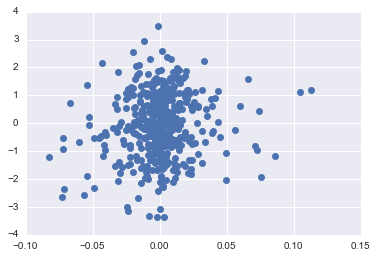

In [41]:
plt.plot(best_beta, sgd_betas, 'o')

In [42]:
contribute_off = np.argsort(-sgd_betas)# * player_info['PTS'])
betas_df_sgd = player_info.loc[contribute_off]
betas_df_sgd['beta'] = sgd_betas[contribute_off]
betas_df_sgd.head(10)

,Player,Tm,2015-16,Pos,Age,G,GS,MP,FG,FGA,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,beta
92,Markieff Morris,Washington Wizards,8000000,PF,26,64,45,25.5,4.8,11.2,...,1.1,4.4,5.5,1.9,0.9,0.5,2.1,2.9,12.0,3.480976
256,Evan Fournier,Orlando Magic,2288205,SF,23,79,71,32.5,5.4,11.8,...,0.4,2.4,2.8,2.7,1.2,0.0,1.7,2.7,15.4,2.935645
140,Deron Williams,Dallas Mavericks,5500000,PG,31,65,63,32.4,4.9,11.9,...,0.3,2.6,2.9,5.8,0.9,0.2,2.3,2.4,14.1,2.572073
36,DeMarcus Cousins,Sacramento Kings,14728844,C,25,65,65,34.6,9.2,20.5,...,2.4,9.1,11.5,3.3,1.6,1.4,3.8,3.6,26.9,2.549556
437,Lamar Patterson,Atlanta Hawks,525093,SG,24,35,0,11.3,0.8,2.3,...,0.1,1.3,1.4,1.1,0.3,0.1,0.7,1.3,2.4,2.380307
255,Myles Turner,Indiana Pacers,2357760,C,19,60,30,22.8,4.4,8.8,...,1.1,4.4,5.5,0.7,0.4,1.4,1.1,2.6,10.3,2.295949
97,Ersan Ilyasova,Orlando Magic,7900000,PF,28,74,56,25.4,3.8,8.9,...,1.9,3.5,5.4,0.9,0.7,0.4,1.0,2.3,10.4,2.295701
111,Isaiah Thomas,Boston Celtics,6912869,PG,26,82,79,32.2,7.2,16.9,...,0.6,2.4,3.0,6.2,1.1,0.1,2.7,2.0,22.2,2.245256
1,Joe Johnson,Brooklyn Nets,24894863,SF,34,81,81,33.4,4.7,10.6,...,0.6,3.0,3.6,3.9,0.8,0.0,2.0,1.8,12.2,2.157552
94,O.J. Mayo,Milwaukee Bucks,8000000,SG,28,41,24,26.6,2.9,7.8,...,0.3,2.2,2.6,2.9,1.2,0.2,1.8,3.1,7.8,2.093698


## Prediction

In [52]:
# subset the data into first half and second half of the season

def split_game_data(game_diff, host_matrix, guest_matrix,
                    guest_lineup_arr, host_lineup_arr, prop_split = 0.5):
    
    assert(game_diff.shape[0] == host_matrix.shape[0])
    assert(host_matrix.shape == guest_matrix.shape)
    assert(guest_lineup_arr.shape == host_lineup_arr.shape)
    assert(guest_lineup_arr.shape[0] == game_diff.shape[0])
    assert(prop_split > 0 and prop_split < 1)
    
    ngames = game_diff.shape[0]
    ngames_train = int(prop_split * ngames)
    
    game_diff_train = game_diff[:ngames_train]
    game_diff_test = game_diff[ngames_train:]
    
    host_matrix_train = host_matrix[:ngames_train]
    host_matrix_test = host_matrix[ngames_train:]
    
    guest_matrix_train = guest_matrix[:ngames_train]
    guest_matrix_test = guest_matrix[ngames_train:]
    
    guest_lineup_arr_train = guest_lineup_arr[:ngames_train]
    guest_lineup_arr_test = guest_lineup_arr[ngames_train:]
    
    host_lineup_arr_train = host_lineup_arr[:ngames_train]
    host_lineup_arr_test = host_lineup_arr[ngames_train:]
    
    return(game_diff_train, game_diff_test,
           host_matrix_train, host_matrix_test,
           guest_matrix_train, guest_matrix_test,
           guest_lineup_arr_train, guest_lineup_arr_test,
           host_lineup_arr_train, host_lineup_arr_test)

In [135]:
splitted = split_game_data(game_diff, host_matrix, guest_matrix,
                           guest_lineup_arr, host_lineup_arr, 0.80)

# super ugly :(
game_diff_train, game_diff_test, host_matrix_train, host_matrix_test, \
guest_matrix_train, guest_matrix_test, guest_lineup_arr_train, guest_lineup_arr_test, \
host_lineup_arr_train, host_lineup_arr_test = splitted

In [136]:
coefs = np.random.randn(2*(nplayers + nteams) + 1)
extra_args_train = (game_diff_train, off_rating, def_rating, nplayers,
              nteams, guest_matrix_train, host_matrix_train,
              guest_lineup_arr_train, host_lineup_arr_train, 1)

opt_res_train = scipy.optimize.minimize(negloglik, coefs, extra_args_train,
                       jac = negloglik_grad, method = "L-BFGS-B")

In [144]:
print(opt_res_train['success'])

True


In [137]:
coefs_trained = opt_res_train['x']

In [138]:
def predict_fitted(coefs, off_rating, def_rating, nplayers, nteams,
           guest_matrix, host_matrix, guest_lineup_arr, host_lineup_arr):
    ''' evaluate the predictive power of fitted coefficients coefs '''
    beta0, betas, gamma0, gammas, logsigma = \
            split_params(coefs, nplayers, nteams)
    
    ngames = game_diff.shape[0]
    
    guest_off_0 = np.dot(guest_matrix, beta0)
    guest_def_0 = np.dot(guest_matrix, gamma0)
    host_off_0 = np.dot(host_matrix, beta0)
    host_def_0 = np.dot(host_matrix, gamma0)
    
    guest_off = guest_off_0 + np.dot(guest_lineup_arr, betas * off_rating)
    guest_def = guest_def_0 + np.dot(guest_lineup_arr, gammas * def_rating)
    host_off = host_off_0 + np.dot(host_lineup_arr, betas * off_rating)
    host_def = host_def_0 + np.dot(host_lineup_arr, gammas * def_rating)
    
    predict_diff = guest_off - host_def - (host_off - guest_def)
    
    return(predict_diff)


In [139]:
predict_diff = predict_fitted(coefs_trained, off_rating, def_rating,
                                  nplayers, nteams,
                                  guest_matrix_test, host_matrix_test,
                                  guest_lineup_arr_test, host_lineup_arr_test)

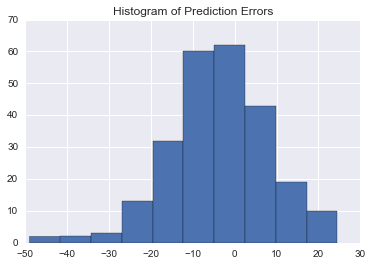

In [140]:
errors = (game_diff_test - predict_diff)
plt.hist(errors)
plt.title("Histogram of Prediction Errors")
plt.show()

In [141]:
np.mean(game_diff_test * predict_diff > 0)

0.7032520325203252

In [142]:
np.sqrt(np.mean(prediction_errors**2))

12.197665250730006